# Multi-head Network with Mask R-CNN


## Introduction
Multi-head (or multi-task) network is a network that can do several tasks. There are several networks that have several heads to handle different tasks (segmentation, object detection, pose estimation, etc.). In this tutorial, we will discuss [Mask R-CNN](https://arxiv.org/abs/1703.06870) which is a famous network for **instance segmentation**.

![](https://kharshit.github.io/img/ibrahim-rifath-D0x1GOoiPzw-unsplash_inst_seg.jpg)


## Instance Segmentation
In a simple term, **instance segmentation** is a combination of **semantic segmentation** and **object detection**. The figure below shows a comparison between these:

![](https://kharshit.github.io/img/segmentation.png)


Instance segmentation and semantic segmentation differ in two ways:

- In semantic segmentation, every pixel is assigned a class label, while in instance segmentation, that is not the case.

- We do not tell the instances of the same class apart in semantic segmentation. For example, all pixels belonging to the “person” class in semantic segmentation will be assigned the same color/value in the mask. In instance segmentation, they are assigned different values, and we can tell them which pixels correspond to which person. We can see this in the above image.

## Mask R-CNN

The architecture of Mask R-CNN is an extension of [Faster R-CNN](https://arxiv.org/abs/1506.01497), which is an object detector.

Mask R-CNN has these main components: Convolutional Layers, Region Proposal Network (RPN), RoI pooling layer, and 2 heads (one for object class, and one for segmentation).

**Reading the Mask-RCNN paper is strongly recommended.**

![](https://learnopencv.com/wp-content/uploads/2019/06/mask-rcnn-768x358.jpg)

## Implementation

The implementation of Mask R-CNN can be found in [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Here we use the implementation directly

In [5]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

### Initialize Mask R-CNN and download pretrained weights

In [6]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cpu()

c:\Users\Paramveer Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Paramveer Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\Paramveer Singh/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
40.8%


KeyboardInterrupt: 

### Detect objects on a test image

First, dowload a test image from internet:

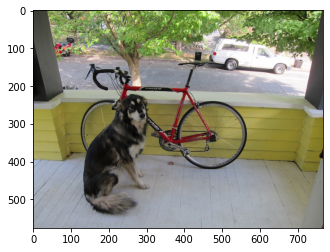

In [5]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/dog.jpg'


image_file = basename(IMAGE_URL)
!wget -q -O {image_file} {IMAGE_URL}
plt.imshow(matplotlib.image.imread(image_file))

Execute  Mask R-CNN model on that image and show the result:

In [6]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
output = model([image_tensor])[0]
print('executed in %.3fs' % (time.time() - t))

executed in 6.050s


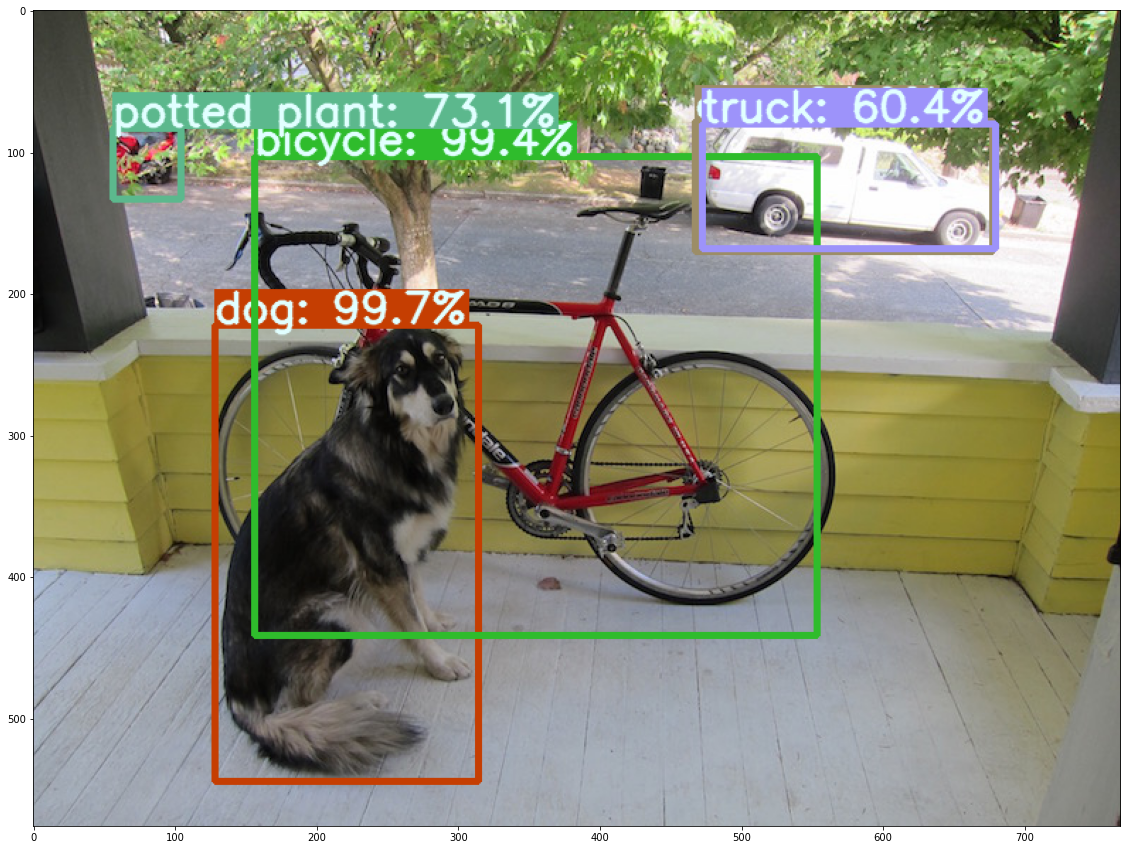

In [7]:
coco_names = ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
colors = [[random.randint(0, 255) for _ in range(3)] for _ in coco_names]

result_image = np.array(image.copy())
for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
  if score > 0.5:
    color = random.choice(colors)
    
    # draw box
    tl = round(0.002 * max(result_image.shape[0:2])) + 1  # line thickness
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(result_image, c1, c2, color, thickness=tl)
    # draw text
    display_txt = "%s: %.1f%%" % (coco_names[label], 100*score)
    tf = max(tl - 1, 1)  # font thickness
    t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
    c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    cv2.rectangle(result_image, c1, c2, color, -1)  # filled
    cv2.putText(result_image, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
  
plt.figure(figsize=(20, 15))
plt.imshow(result_image)

Show masks for the above objects:

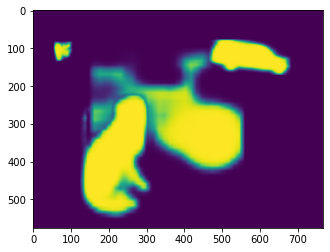

In [8]:
masks = None
for score, mask in zip(output['scores'], output['masks']):
  if score > 0.5:
    if masks is None:
      masks = mask
    else:
      masks = torch.max(masks, mask)

plt.imshow(masks.squeeze(0).cpu().numpy())

Below is my  code for question 3 and 4:

In [1]:
import cv2
import torch
import numpy as np
import random
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Function to draw the principal axes
def draw_principal_axes(image, center, axes):
    cv2.circle(image, center, 5, (255, 0, 0), -1)  # Draw the center
    cv2.line(image, center, axes[0], (0, 255, 0), 2)  # Principal axis 1
    cv2.line(image, center, axes[1], (0, 0, 255), 2)  # Principal axis 2

# Function to calculate the center and axes of the mask
def find_principal_axes_and_center(mask):
    ret, thresh = cv2.threshold(mask, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None, None

    # Find the largest contour assuming it corresponds to the object mask
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the center of the mask using moments
    M = cv2.moments(largest_contour)
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    center = (center_x, center_y)

    # Perform PCA
    data_pts = np.array([pt[0] for pt in largest_contour], np.float32)
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=None)

    # Scale and draw the principal axes
    axis_1_end = (int(mean[0,0] + eigenvectors[0,0] * 100), int(mean[0,1] + eigenvectors[0,1] * 100))
    axis_2_end = (int(mean[0,0] + eigenvectors[1,0] * 50), int(mean[0,1] + eigenvectors[1,1] * 50))

    return center, (axis_1_end, axis_2_end)

# Initialize the model
model = maskrcnn_resnet50_fpn(pretrained=True).eval().cpu()

# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the webcam
cap = cv2.VideoCapture(0)

# Define the transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Run the webcam loop
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image for the model
    image = transform(frame).to(device)

    # Get predictions from the model
    with torch.no_grad():
        prediction = model([image])[0]
    
    coco_names = [
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

    for element in range(len(prediction["masks"])):
        score = prediction["scores"][element].item()
        if score > 0.5:  # only consider detections with confidence > 0.5
            mask = prediction["masks"][element, 0]
            mask = mask.mul(255).byte().cpu().numpy()
            thresh = mask > 127  # threshold out the mask
            vis_mask = np.zeros_like(frame, dtype=np.uint8)
            color = [random.randint(0, 255) for _ in range(3)]
            
            # We need to repeat the mask for each channel and apply it
            for i in range(3):
                vis_mask[thresh, i] = color[i]
            
            frame = cv2.addWeighted(frame, 1.0, vis_mask, 0.5, 0)

            # Draw the bounding box
            box = prediction["boxes"][element].cpu().numpy().astype(np.int32)
            frame = cv2.rectangle(frame, tuple(box[:2]), tuple(box[2:]), color, 2)
            
            # Draw the label
            label_idx = prediction["labels"][element].item()  # Get the label index
            label = coco_names[label_idx] if label_idx < len(coco_names) else 'Unknown'
            label_text = f'{label}: {score:.2f}'
            cv2.putText(frame, label_text, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            mask = prediction["masks"][element, 0]
            mask = mask.mul(255).byte().cpu().numpy()
            
            # Calculate principal axes and center of the mask
            center, axes = find_principal_axes_and_center(mask)
            if center is not None and axes is not None:
                draw_principal_axes(frame, center, axes)

    # Display the frame with mask and boxes
    cv2.imshow('Mask R-CNN Webcam', frame)

    # Break loop with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()



c:\Users\Paramveer Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Paramveer Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

: 

## Self-study task

- Use the OpenCV library to get the image stream from a webcam. 
- Feed this image stream to the Mask-RCNN network
- Visualize the results. 

We then will have the very first network that can be used in some robotic grasping tasks!